# Boletín 5 - SVM

### Importar las librerías y fijar la semilla

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [23]:
%matplotlib inline
matplotlib.style.use('ggplot')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  # Para evitar warnings en algunas gráficas

In [24]:
SEED_VALUE = 1

## Ejercicio 2: Clasificación - Blood Transfusion Service Center


In [25]:
DATASET_NAME = 'bloodTransfusion.data'
DATASET_DELIMITER = ','

### Leemos el fichero de datos

In [26]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "MarchDonor"])
dataset

,Recency,Frequency,Monetary,Time,MarchDonor
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
5,4,4,1000,4,0
6,2,7,1750,14,1
7,1,12,3000,35,0
8,2,9,2250,22,1
9,5,46,11500,98,1


El fichero contiene 5 variables y 748 observaciones. Las variables predictoras son `Recency`, `Frequency`, `Monetary`, `Time`, y la variable dependiente sería `MarchDonor`. Es una clasificación binaria - existen 2 clases `0`(no ha donado sangre) y  `1` (ha donado sangre).

## Visualizamos los datos

Visualizamos la distribución de variables por clases.

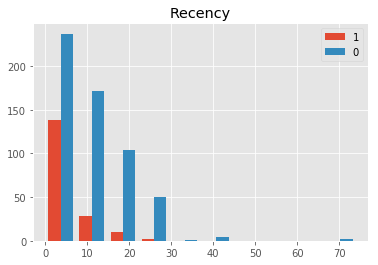

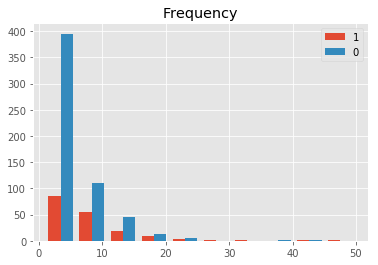

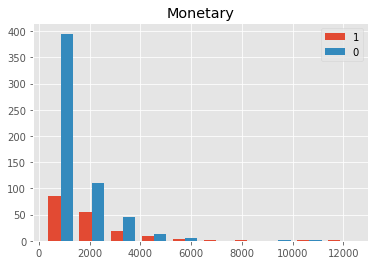

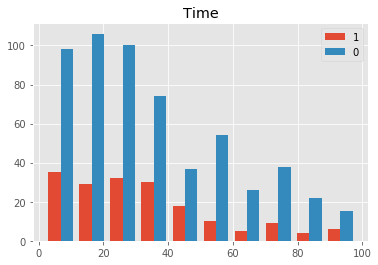

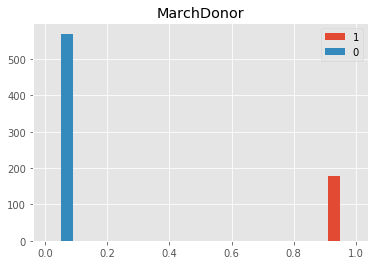

In [7]:
for column in dataset:  
    plt.title(column)
    plt.hist([dataset[dataset['MarchDonor'] == 1][column], dataset[dataset['MarchDonor'] == 0][column]], label=['1', '0'])
    plt.legend(loc='upper right')
    plt.show()

Visualizar los datos y sus clases por pares de atributos mostrando también la clase con color.

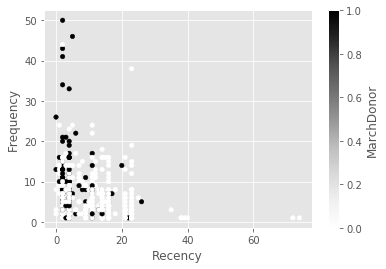

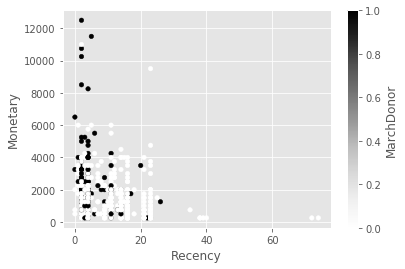

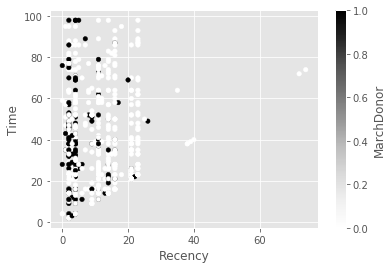

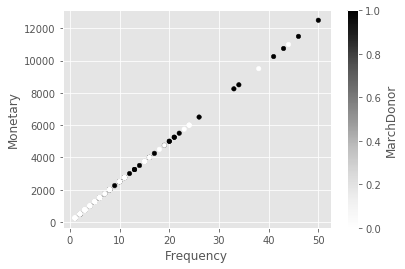

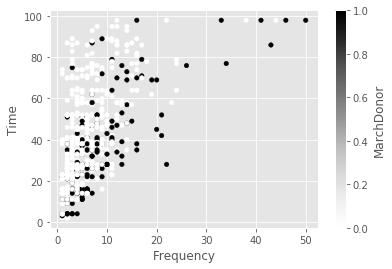

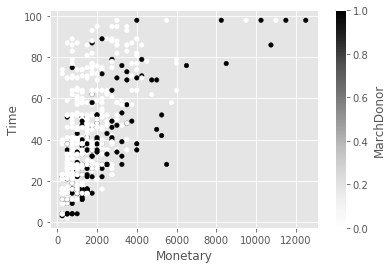

In [16]:
column_names = dataset.columns[:-1]  
for i, columna_i in enumerate(column_names):
    for j, columna_j in enumerate(column_names):
        if i < j:
            fig, ax = plt.subplots()
            dataset.plot.scatter(columna_i, columna_j, c='MarchDonor', ax=ax)

Se ve que hay correlación entre las variables Frequency que representa el número total de donaciones y Monetary - la cantidad total de la sagre donada. Esto tiene sentido. Sin embargo, cuando usamos KNN la correlación entre variables no afecta el modelo por esto trabajaremos con todas las variables de entrada.

### División de los datos en entrenamiento (80%) y test (20%)

Dividimos los datos en entrenamiento y test usando la samilla y estratificamos por la variable de salida MarchDonor para mantener la misma proporción en el conjunto de entrenamiento y en el conjunto de test.

In [27]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=dataset["MarchDonor"])
dataset_test

,Recency,Frequency,Monetary,Time,MarchDonor
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
722,21,3,750,40,0
740,23,1,250,23,0
568,4,6,1500,35,1
539,2,2,500,4,1
244,9,2,500,11,0


### Separación de variables predictoras y dependientes

Separamos los conjutos de test creando un dataframe para las variables de entrada y un para la de salida.

In [28]:
dataset_train_X = dataset_train.loc[:, "Recency":"Time"].astype(float)
dataset_train_Y = dataset_train.loc[:, "MarchDonor"]

dataset_test_X = dataset_test.loc[:, "Recency":"Time"].astype(float)
dataset_test_Y = dataset_test.loc[:, "MarchDonor"]

dataset_test_X

,Recency,Frequency,Monetary,Time
309,16.0,3.0,750.0,19.0
711,23.0,6.0,1500.0,45.0
343,11.0,1.0,250.0,11.0
462,21.0,1.0,250.0,21.0
646,14.0,2.0,500.0,14.0
722,21.0,3.0,750.0,40.0
740,23.0,1.0,250.0,23.0
568,4.0,6.0,1500.0,35.0
539,2.0,2.0,500.0,4.0
244,9.0,2.0,500.0,11.0


## Estandarización de los datos

Es un problema de clasificación estandarizamos solo las variables de entrada. Usamos el método StandardScaler() y 
calculamos la media y la desviacion sobre el conjunto de entrenamiento

In [29]:
scaler = StandardScaler()

scaler.fit(dataset_train_X)

dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

dataset_test_X_scaled

array([[ 8.22450908e-01, -4.47487686e-01, -4.47487686e-01,
        -6.42119939e-01],
       [ 1.70930807e+00,  6.15756676e-02,  6.15756676e-02,
         4.09236507e-01],
       [ 1.88981507e-01, -7.86863255e-01, -7.86863255e-01,
        -9.65614230e-01],
       [ 1.45592031e+00, -7.86863255e-01, -7.86863255e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
        -8.44303871e-01],
       [ 1.45592031e+00, -4.47487686e-01, -4.47487686e-01,
         2.07052575e-01],
       [ 1.70930807e+00, -7.86863255e-01, -7.86863255e-01,
        -4.80372793e-01],
       [-6.97875655e-01,  6.15756676e-02,  6.15756676e-02,
         4.86864317e-03],
       [-9.51263415e-01, -6.17175470e-01, -6.17175470e-01,
        -1.24867173e+00],
       [-6.44062535e-02, -6.17175470e-01, -6.17175470e-01,
        -9.65614230e-01],
       [-6.97875655e-01,  4.00951237e-01,  4.00951237e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
      

Estos son los valores con los que se ha estandarizado.

In [30]:
print("mean [Recency, Frequency, Monetary, Time]: {}  |  std [Recency, Frequency, Monetary, Time]: {}".format(scaler.mean_, scaler.scale_))

mean [Recency, Frequency, Monetary, Time]: [   9.5083612     5.63712375 1409.28093645   34.87959866]  |  std [Recency, Frequency, Monetary, Time]: [   7.89304107    5.89317612 1473.29403119   24.72995729]


## Experimentación SVC

## Kernel Lineal

### Definimos un rango de hiperparámetros para realizar las pruebas

In [21]:
C = list()
for i in range(-4,8):
    C.append(10**i)

hyperparameters = { 'kernel' : ['linear'],
                    'C' : C} 
print(C)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]


### Comenzamos las pruebas con 5-CV

Hacemos validación cruzada.

In [22]:
svc = SVC(random_state=SEED_VALUE)

modelCV = GridSearchCV(svc,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)  

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [23]:
#with open('SVC_linear.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

### Resultados obtenidos en 5-CV

Puede verse el ranking de los mejores

In [31]:
with open('SVC_linear.pkl', 'rb') as f:
    restored_model_linear = pickle.load(f)

In [32]:
cv_results = pd.DataFrame(restored_model_linear.cv_results_)
cv_results.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.0001,0.762542,0.002709,3
1,linear,0.001,0.762542,0.002709,3
2,linear,0.01,0.762542,0.002709,3
3,linear,0.1,0.760870,0.003370,6
4,linear,1,0.760870,0.003370,6
5,linear,10,0.760870,0.003370,6
6,linear,100,0.760870,0.003370,6
7,linear,1000,0.760870,0.003370,6
8,linear,10000,0.760870,0.003370,6
9,linear,100000,0.765886,0.009976,2


Los mejores hiperparámetros en validación serían los siguientes. 

In [33]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
10,linear,1000000,0.767559,0.029548,1


Calculamos el error del mejor hiperparámetro:

In [34]:
1 - cv_results_best.loc[10, ['mean_test_score']].values[0]

0.2324414715719063

### Gráfica de entrenamiento

Hacemos la gráfica de entrenamiento para visualizar el error correspodiente a cada uno de los hiperparámentros. Es este caso decido dejar solo los valores de uniform poorque despues de generar la gráfica por primera vez me di cuenta de que en general con distance el error es mucho más grande en cada uno de los casos y no me serve comparar con estos valores. Además buscamos el modelo más simple y los modelos uniform son más simples.

Aplicamos la regla de un un error estandar hacia la derecha porque el modelo más sencillo. En el caso de KNN los modelos más sencillos son ellos con mayor número de vecinos.

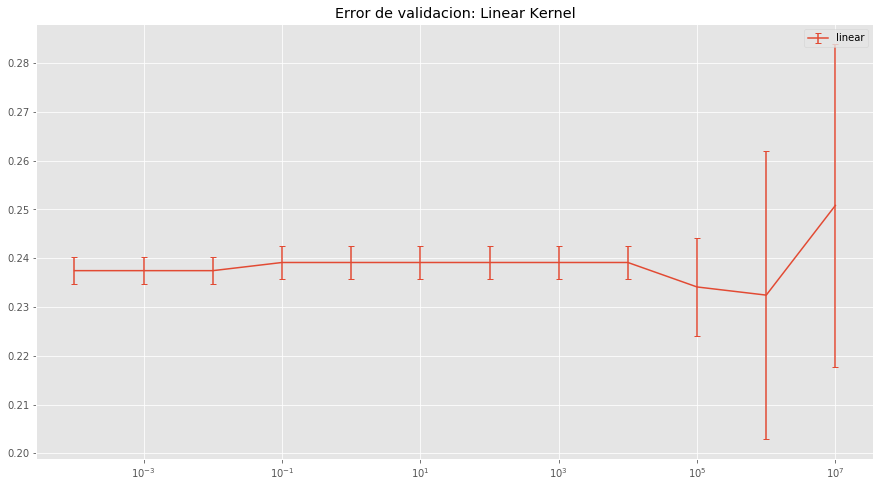

In [19]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: Linear Kernel")
plt.errorbar(cv_results['param_C'],1 - cv_results['mean_test_score'], cv_results['std_test_score'], label='linear', capsize=3)  

plt.xscale('log', nonposx='clip')
plt.legend(loc='upper right')
plt.show()

### Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`C = 1000000`) y con todo el conjunto de entrenamiento. 

In [17]:
model = SVC( kernel = 'linear', C = 1000000, random_state=SEED_VALUE)

np.random.seed(SEED_VALUE)  
model.fit(dataset_train_X_scaled, dataset_train_Y)

SVC(C=1000000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False)

### Evaluación del modelo en el conjunto de test

Después de "entrenar" el modelo con todo el conjunto de entrenamiento ya los podemos aplicar al conjunto de test. Guardamos la predicción del modelo en la variable Z.

In [18]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

Hacemos una comparación entre las predicciones en Z y los valores reales.

In [19]:
accuracy_test = accuracy_score(dataset_test_Y, Z) 
print("Accuracy en test: {}  |  Error en test: {}".format(accuracy_test, 1-accuracy_test))

Accuracy en test: 0.76  |  Error en test: 0.24


### Verificación de nuestros hiperparámetros

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo y nuestro conjunto de validación va a ser el conjunto de test.

In [20]:
# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) #divicion de datos

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

C = list()
for i in range(-4,7):
    C.append(10**i)

hyperparameters = { 'kernel' : ['linear'],
                    'C' : C} 

svc = SVC(random_state=SEED_VALUE)
modelCV = GridSearchCV(svc,
                       hyperparameters,
                       cv=ps, 
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [21]:
#with open('SVC_linear_test.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

Obtenemos los resultados de la validación con el conjunto de test.

In [20]:
with open('SVC_linear_test.pkl', 'rb') as f:
    restored_model_linear = pickle.load(f)

In [21]:
test_results = pd.DataFrame(restored_model_linear.cv_results_)
test_results.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.0001,0.76,0.0,2
1,linear,0.001,0.76,0.0,2
2,linear,0.01,0.76,0.0,2
3,linear,0.1,0.76,0.0,2
4,linear,1,0.76,0.0,2
5,linear,10,0.76,0.0,2
6,linear,100,0.76,0.0,2
7,linear,1000,0.76,0.0,2
8,linear,10000,0.76,0.0,2
9,linear,100000,0.78,0.0,1


Vizualizamos el error en el conjunto de entrenamiento y también el error en el conjunto de test para ver si nuestro modelo ha hecho buen trabajo.

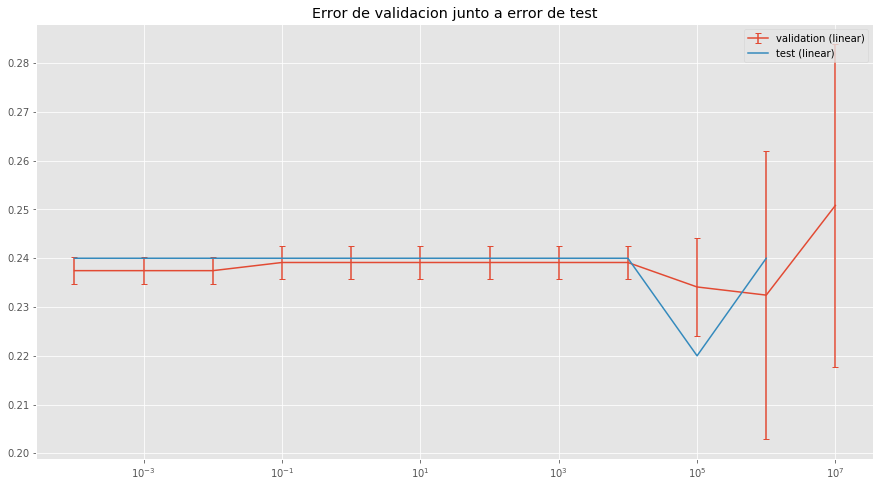

In [22]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion junto a error de test")

plt.errorbar(cv_results['param_C'],1 - cv_results['mean_test_score'], cv_results['std_test_score'], label='validation (linear)', capsize=3)  
plt.errorbar(test_results['param_C'],1 - test_results['mean_test_score'], label='test (linear)', capsize=3) 

plt.xscale('log', nonposx='clip')
plt.legend(loc='upper right')
plt.show()


Parece que el menor error de test se obtendría con valores del híperparámetro entre ??

## Polynomial Kernel

### Definimos un rango de hiperparámetros para realizar las pruebas

In [12]:
C = list()
for i in range(-6,2):
    C.append(10**i)

hyperparameters = { 'kernel' : ['poly'],
                    'C' : C,
                    'degree' : [2,3,4,5],
                    'gamma': [1]} 
print(C)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


### Comenzamos las pruebas con 5-CV

Hacemos validación cruzada.

In [ ]:
svc = SVC(random_state=SEED_VALUE)

modelCV = GridSearchCV(svc,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)

In [ ]:
with open('SVC_poly.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

### Resultados obtenidos en 5-CV

Puede verse el ranking de los mejores

In [35]:
with open('SVC_poly.pkl', 'rb') as f:
    restored_model_poly = pickle.load(f)

In [36]:
cv_results = pd.DataFrame(restored_model_poly.cv_results_)
cv_results.loc[:, ['param_kernel', 'param_degree' ,'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_degree,param_C,mean_test_score,std_test_score,rank_test_score
0,poly,2,1e-06,0.762542,0.002709,13
1,poly,3,1e-06,0.760870,0.003370,25
2,poly,4,1e-06,0.762542,0.003744,13
3,poly,5,1e-06,0.759197,0.010360,29
4,poly,2,1e-05,0.762542,0.002709,13
5,poly,3,1e-05,0.762542,0.003744,13
6,poly,4,1e-05,0.760870,0.006792,25
7,poly,5,1e-05,0.760870,0.011705,25
8,poly,2,0.0001,0.760870,0.003370,25
9,poly,3,0.0001,0.764214,0.004200,6


Los mejores hiperparámetros en validación serían los siguientes. 

In [37]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_kernel', 'param_degree', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_degree,param_C,mean_test_score,std_test_score,rank_test_score
25,poly,3,1,0.769231,0.013420,1
29,poly,3,10,0.769231,0.013420,1
30,poly,4,10,0.769231,0.014089,1


Calculamos el error del mejor hiperparámetro:

In [52]:
1 - cv_results_best.loc[25, ['mean_test_score']].values[0]

0.23076923076923073

### Gráfica de entrenamiento

Hacemos la gráfica de entrenamiento para visualizar el error correspodiente a cada uno de los hiperparámentros. Es este caso decido dejar solo los valores de uniform poorque despues de generar la gráfica por primera vez me di cuenta de que en general con distance el error es mucho más grande en cada uno de los casos y no me serve comparar con estos valores. Además buscamos el modelo más simple y los modelos uniform son más simples.

Aplicamos la regla de un un error estandar hacia la derecha porque el modelo más sencillo. En el caso de KNN los modelos más sencillos son ellos con mayor número de vecinos.

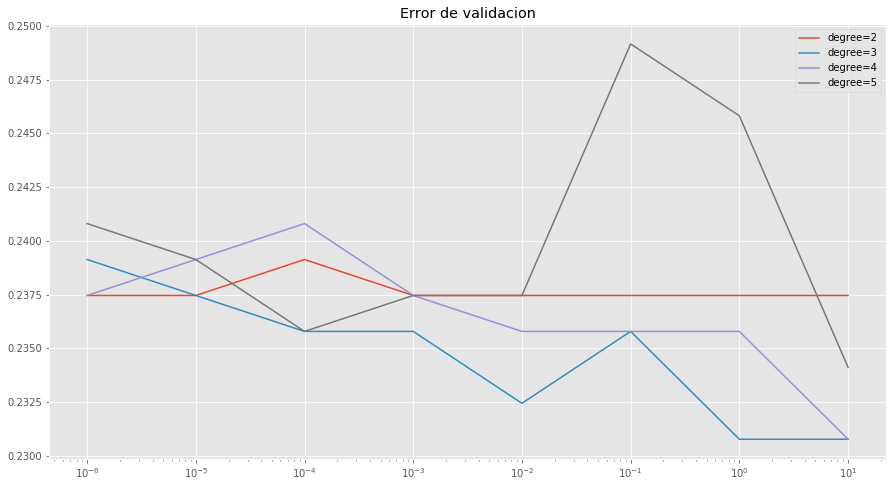

In [54]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion")

d = [2,3,4,5]
for i in d:
    plt.errorbar(cv_results['param_C'].loc[cv_results['param_degree'] == i],1 - cv_results['mean_test_score'].loc[cv_results['param_degree'] == i], label='degree=' + str(i), capsize=3)  

plt.xscale('log', nonposx='clip')
plt.legend(loc='upper right')
plt.show()

In [2]:
C = list()
for i in range(-4,4):
    C.append(10**i)

hyperparameters = { 'kernel' : ['poly'],
                    'C' : C,
                    'degree' : [3],
                    'gamma': [1]} 
print(C)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


In [ ]:
svc = SVC(random_state=SEED_VALUE)

modelCV = GridSearchCV(svc,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)

with open('SVC_poly_C_large_degree_3.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open('SVC_poly_C_large_degree_3.pkl', 'rb') as f:
    restored_model_poly = pickle.load(f)

In [39]:
cv_results = pd.DataFrame(restored_model_poly.cv_results_)
cv_results.loc[:, ['param_kernel', 'param_degree' ,'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_degree,param_C,mean_test_score,std_test_score,rank_test_score
0,poly,3,0.0001,0.764214,0.004200,6
1,poly,3,0.001,0.764214,0.013074,6
2,poly,3,0.01,0.767559,0.007115,5
3,poly,3,0.1,0.764214,0.013074,6
4,poly,3,1,0.769231,0.013420,3
5,poly,3,10,0.769231,0.013420,3
6,poly,3,100,0.770903,0.013747,2
7,poly,3,1000,0.772575,0.025591,1


In [40]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_kernel', 'param_degree', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_degree,param_C,mean_test_score,std_test_score,rank_test_score
7,poly,3,1000,0.772575,0.025591,1


In [41]:
1 - cv_results_best.loc[7, ['mean_test_score']].values[0]

0.22742474916387956

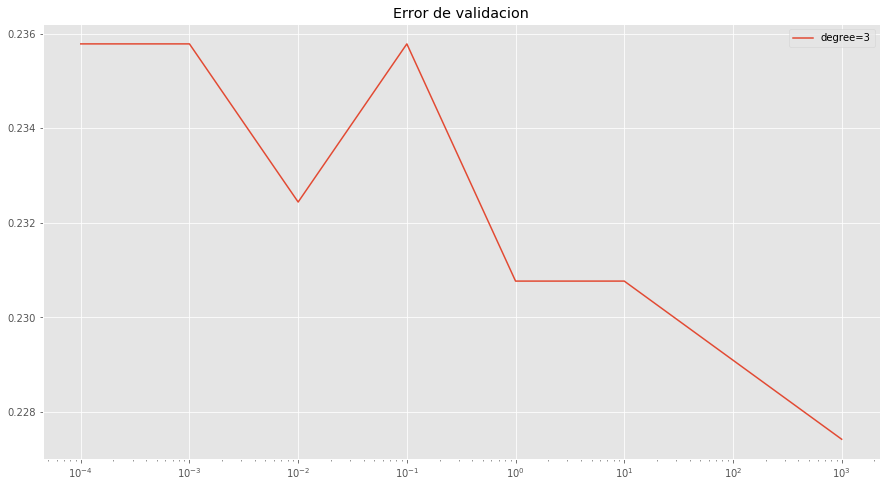

In [42]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion")

d = [3]
for i in d:
    plt.errorbar(cv_results['param_C'].loc[cv_results['param_degree'] == i],1 - cv_results['mean_test_score'].loc[cv_results['param_degree'] == i], label='degree=' + str(i), capsize=3)  

plt.xscale('log', nonposx='clip')
plt.legend(loc='upper right')
plt.show()

### Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`param_C = 1000`, `degree = 3`) y con todo el conjunto de entrenamiento. 

In [23]:
model = SVC(kernel = 'poly', C = 1000, degree = 3, random_state=SEED_VALUE)

np.random.seed(SEED_VALUE)  
model.fit(dataset_train_X_scaled, dataset_train_Y)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False)

### Evaluación del modelo en el conjunto de test

Después de "entrenar" el modelo con todo el conjunto de entrenamiento ya los podemos aplicar al conjunto de test. Guardamos la predicción del modelo en la variable Z.

In [24]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

Hacemos una comparación entre las predicciones en Z y los valores reales.

In [25]:
accuracy_test = accuracy_score(dataset_test_Y, Z) 
print("Accuracy en test: {}  |  Error en test: {}".format(accuracy_test, 1-accuracy_test))

Accuracy en test: 0.773333333333  |  Error en test: 0.226666666667


### Verificación de nuestros hiperparámetros

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo y nuestro conjunto de validación va a ser el conjunto de test.

In [ ]:
# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) #divicion de datos

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

C = list()
for i in range(-4,4):
    C.append(10**i)

hyperparameters = { 'kernel' : ['poly'],
                    'C' : C,
                    'degree' : [3],
                    'gamma': [1]} 

svc = SVC(random_state=SEED_VALUE)
modelCV = GridSearchCV(svc,
                       hyperparameters,
                       cv=ps, 
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_all_X_scaled, dataset_all_Y)

In [20]:
with open('SVC_poly_C_large_degree_3_test.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

Obtenemos los resultados de la validación con el conjunto de test.

In [43]:
with open('SVC_poly_C_large_degree_3_test.pkl', 'rb') as f:
    restored_model_poly_test = pickle.load(f)

In [44]:
test_results = pd.DataFrame(restored_model_poly_test.cv_results_)
test_results.loc[:, ['param_kernel', 'param_degree' , 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_degree,param_C,mean_test_score,std_test_score,rank_test_score
0,poly,3,0.0001,0.766667,0.0,7
1,poly,3,0.001,0.766667,0.0,7
2,poly,3,0.01,0.773333,0.0,2
3,poly,3,0.1,0.773333,0.0,2
4,poly,3,1,0.773333,0.0,2
5,poly,3,10,0.773333,0.0,2
6,poly,3,100,0.773333,0.0,2
7,poly,3,1000,0.780000,0.0,1


Vizualizamos el error en el conjunto de entrenamiento y también el error en el conjunto de test para ver si nuestro modelo ha hecho buen trabajo.

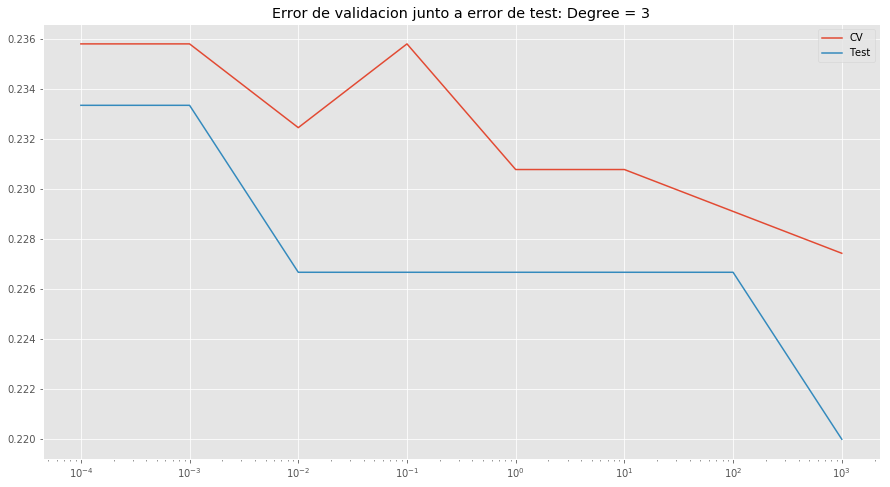

In [45]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion junto a error de test: Degree = 3")


plt.errorbar(cv_results['param_C'].loc[cv_results['param_degree'] == 3],1 - cv_results['mean_test_score'].loc[cv_results['param_degree'] == 3], label='CV', capsize=3)
plt.errorbar(test_results['param_C'].loc[cv_results['param_degree'] == 3],1 - test_results['mean_test_score'].loc[test_results['param_degree'] == 3], label='Test', capsize=3)  

plt.xscale('log', nonposx='clip')
plt.legend(loc='upper right')
plt.show()


## Kernel Radial

### Definimos un rango de hiperparámetros para realizar las pruebas

In [71]:
C = list()
for i in range(-4,7):
    C.append(10**i)
    
gamma = list()
for i in range(-6,5):
    gamma.append(10**i)

hyperparameters = { 'kernel' : ['rbf'],
                    'C' : C,
                    'gamma' : gamma} 
print(C)
print(gamma)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


### Comenzamos las pruebas con 5-CV

Hacemos validación cruzada.

In [72]:
svc = SVC(random_state=SEED_VALUE)

modelCV = GridSearchCV(svc,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)  

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], 'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [73]:
with open('SVC_radial.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

### Resultados obtenidos en 5-CV

Puede verse el ranking de los mejores

In [74]:
with open('SVC_radial.pkl', 'rb') as f:
    restored_model_radial = pickle.load(f)

In [75]:
cv_results = pd.DataFrame(restored_model_radial.cv_results_)
cv_results.loc[:, ['param_kernel', 'param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
0,rbf,0.0001,1e-06,0.762542,0.002709,24
1,rbf,0.0001,1e-05,0.762542,0.002709,24
2,rbf,0.0001,0.0001,0.762542,0.002709,24
3,rbf,0.0001,0.001,0.762542,0.002709,24
4,rbf,0.0001,0.01,0.762542,0.002709,24
5,rbf,0.0001,0.1,0.762542,0.002709,24
6,rbf,0.0001,1,0.762542,0.002709,24
7,rbf,0.0001,10,0.762542,0.002709,24
8,rbf,0.0001,100,0.762542,0.002709,24
9,rbf,0.0001,1000,0.762542,0.002709,24


Los mejores hiperparámetros en validación serían los siguientes. 

In [76]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_kernel', 'param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
50,rbf,1,1,0.797659,0.023503,1


Calculamos el error del mejor hiperparámetro:

In [77]:
1 - cv_results_best.loc[50, ['mean_test_score']].values[0]

0.2023411371237458

### Gráfica de entrenamiento

Hacemos la gráfica de entrenamiento para visualizar el error correspodiente a cada uno de los hiperparámentros. Es este caso decido dejar solo los valores de uniform poorque despues de generar la gráfica por primera vez me di cuenta de que en general con distance el error es mucho más grande en cada uno de los casos y no me serve comparar con estos valores. Además buscamos el modelo más simple y los modelos uniform son más simples.

Aplicamos la regla de un un error estandar hacia la derecha porque el modelo más sencillo. En el caso de KNN los modelos más sencillos son ellos con mayor número de vecinos.

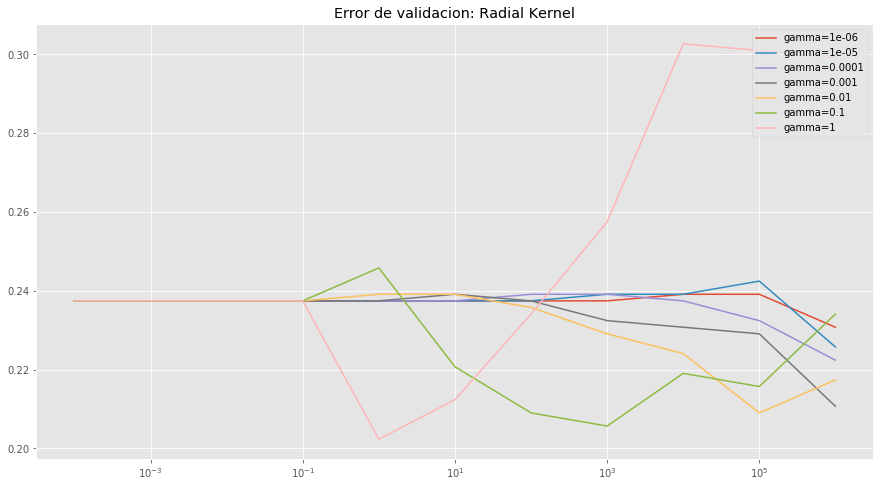

In [85]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: Radial Kernel")

for i in gamma:
    if i <= 1:
        plt.errorbar(cv_results['param_C'].loc[cv_results['param_gamma'] == i],1 - cv_results['mean_test_score'].loc[cv_results['param_gamma'] == i], label='gamma=' + str(i), capsize=3)  


plt.xscale('log', nonposx='clip')
plt.legend(loc='upper right')
plt.show()

### Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`C = 1`, `gamma = 1`) y con todo el conjunto de entrenamiento. 

In [86]:
model = SVC( kernel = 'rbf', C = 1, gamma = 1, random_state=SEED_VALUE)

np.random.seed(SEED_VALUE)  
model.fit(dataset_train_X_scaled, dataset_train_Y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

### Evaluación del modelo en el conjunto de test

Después de "entrenar" el modelo con todo el conjunto de entrenamiento ya los podemos aplicar al conjunto de test. Guardamos la predicción del modelo en la variable Z.

In [87]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

Hacemos una comparación entre las predicciones en Z y los valores reales.

In [88]:
accuracy_test = accuracy_score(dataset_test_Y, Z) 
print("Accuracy en test: {}  |  Error en test: {}".format(accuracy_test, 1-accuracy_test))

Accuracy en test: 0.773333333333  |  Error en test: 0.226666666667


### Verificación de nuestros hiperparámetros

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo y nuestro conjunto de validación va a ser el conjunto de test.

In [89]:
# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) #divicion de datos

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y]) 

svc = SVC(random_state=SEED_VALUE)
modelCV = GridSearchCV(svc,
                       hyperparameters,
                       cv=ps, 
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_all_X_scaled, dataset_all_Y)

with open('SVC_radial_test.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

Obtenemos los resultados de la validación con el conjunto de test.

In [90]:
with open('SVC_radial_test.pkl', 'rb') as f:
    restored_model_radial = pickle.load(f)

In [91]:
test_results = pd.DataFrame(restored_model_radial.cv_results_)
test_results.loc[:, ['param_kernel', 'param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
0,rbf,0.0001,1e-06,0.760000,0.0,39
1,rbf,0.0001,1e-05,0.760000,0.0,39
2,rbf,0.0001,0.0001,0.760000,0.0,39
3,rbf,0.0001,0.001,0.760000,0.0,39
4,rbf,0.0001,0.01,0.760000,0.0,39
5,rbf,0.0001,0.1,0.760000,0.0,39
6,rbf,0.0001,1,0.760000,0.0,39
7,rbf,0.0001,10,0.760000,0.0,39
8,rbf,0.0001,100,0.760000,0.0,39
9,rbf,0.0001,1000,0.760000,0.0,39


Vizualizamos el error en el conjunto de entrenamiento y también el error en el conjunto de test para ver si nuestro modelo ha hecho buen trabajo.

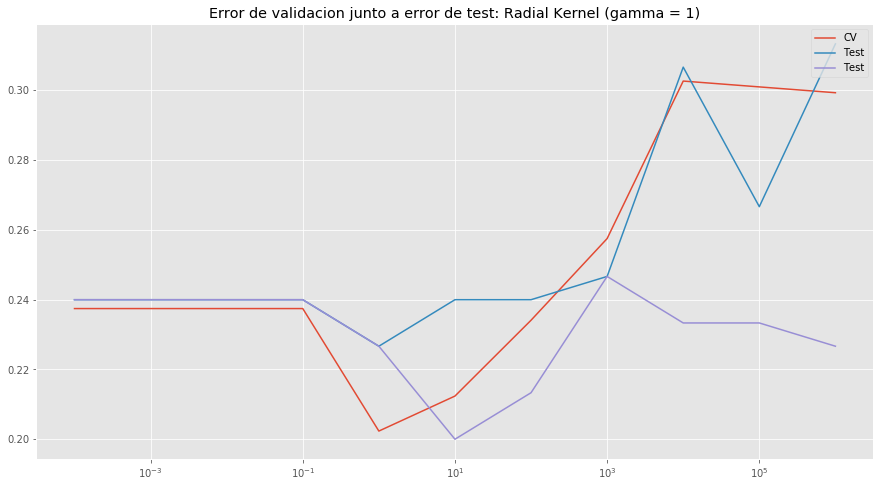

In [93]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion junto a error de test: Radial Kernel (gamma = 1)")

plt.errorbar(cv_results['param_C'].loc[cv_results['param_gamma'] == 1],1 - cv_results['mean_test_score'].loc[cv_results['param_gamma'] == 1], label='CV', capsize=3)
plt.errorbar(test_results['param_C'].loc[cv_results['param_gamma'] == 1],1 - test_results['mean_test_score'].loc[test_results['param_gamma'] == 1], label='Test', capsize=3)  
plt.errorbar(test_results['param_C'].loc[cv_results['param_gamma'] == 0.1],1 - test_results['mean_test_score'].loc[test_results['param_gamma'] == 0.1], label='Test', capsize=3)  
plt.xscale('log', nonposx='clip')
plt.legend(loc='upper right')
plt.show()
